In [0]:
#mounting my drive, for file access
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# install the openslide tools in the OS
!apt-get install openslide-tools

# install the lib for python
!pip install openslide-python

!pip install spams

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (610 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145118 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [0]:
# imports required for the tasks
import openslide as ops # for WSI handling
from skimage.filters.rank import entropy # for image manipulation
from skimage.morphology import disk
from skimage import measure
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern
from skimage.measure import moments
from skimage.filters import gabor
from skimage.color import rgb2gray
from skimage.exposure import histogram
from sklearn.model_selection import KFold, cross_val_score
import numpy as np # for normal computation
import matplotlib.pyplot as plt # for visualization 
import cv2
import h5py
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, moment, skew
from PIL import Image
from tqdm import tqdm

In [0]:
#testing working directory is properly set
working_dir = '/content/drive/My Drive/Colab Notebooks/Kather_texture_2016_image_tiles_5000.zip (Unzipped Files)/Kather_texture_2016_image_tiles_5000'
!ls "$working_dir"
import os

01_TUMOR   03_COMPLEX  05_DEBRIS  07_ADIPOSE  models
02_STROMA  04_LYMPHO   06_MUCOSA  08_EMPTY


In [0]:
#this cell is run once and only once the first time this notebook is opened
#it builds a hdf5 file within which the image files are stored
#this facilitates easy access for training later
datas = h5py.File("/content/drive/My Drive/Colab Notebooks/images.hdf5", "w")

files=[]
files = [f for f in sorted(os.listdir(working_dir))]
print(files)

for d in files:
  dset_size = [len(os.listdir(working_dir+"/"+d)), 150, 150, 3]
  dset = datas.create_dataset(d, dset_size, np.uint8)

  images = [f for f in sorted(os.listdir(working_dir+"/"+d))]
  for i in range(len(images)):
    filename = working_dir+"/"+d+"/"+images[i]
    image = Image.open(filename) #USE PIL to load the image
    image = np.asarray(image)
    image_shape = image.shape #it should be (width, height, 3)
    datas[d][i] = image
    pbar.update(n=1)
pbar.close()
datas.close()

In [0]:
#this tests the files have been saved correctly and loads them back in
#also assembles key list ready for training
filename = '/content/drive/My Drive/Colab Notebooks/images.hdf5'

train = []
test = []
keys = []

with h5py.File(filename, 'r') as f:
    # List all groups
    for key in f.keys():
      length = len(f[key])
      keys.append(key)
      train.append(f[key][:int(length*0.85)])
      test.append(f[key][int(length*0.85):])
#531 in each train set
#94 in each test set
#625 total in each class

print(train[0][0].shape)

(150, 150, 3)


In [0]:
print(keys)

['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']


The following cell builds the list of features for each image, to be used for training the SVM model. The attributes are fairly straightforward, but broadly speaking consist of various measures on the histogram of the image, the lbp histogram of the image, GLCM measures and Gabor filter response measures.

These are all concatenated together to form a 36 feature datapoint for each image that can be used for training/classification purposes later.

In [0]:
features = []
labels = []
angs = [0, np.pi/4, np.pi/2, 3*np.pi/4]
filt = np.zeros((150,150))
from scipy.stats import kurtosis, moment, skew

with tqdm(total = 5000) as pbar:
  with h5py.File(filename, 'r') as f:
    for keyval in range(len(keys)):
      key = keys[keyval]
      label = keyval
      for im in f[key]:
        feature = []
        grayim = rgb2gray(im)
        intgrayim = np.multiply(grayim,255).astype(np.uint8)
        hist = histogram(grayim)[0]
        mean = np.mean(hist)
        var = np.var(hist)
        momf = moment(hist, 5)
        kurt = kurtosis(hist)
        sk = skew(hist)
        mn = min(hist)
        mx = max(hist)
        lbp = local_binary_pattern(grayim, P=8, R=1, method='ror', )
        lbphist = histogram(lbp)[0]
        lmean = np.mean(lbphist)
        lvar = np.var(lbphist)
        lmomf = moment(lbphist, 5)
        lkurt = kurtosis(lbphist)
        lsk = skew(lbphist)
        lmn = min(lbphist)
        lmx = max(lbphist)
        gcm = greycomatrix(intgrayim, distances=[1,2,3,4,5], angles=angs, symmetric=True, normed=True)
        gcp = greycoprops(gcm)
        for ang in angs:
          for pix in [2,4,6,8,10,12]:
            filt += gabor(grayim, frequency=pix, theta=ang)[0]
        filt = np.divide(filt,24)
        fmean = np.mean(filt)
        fvar = np.var(filt)

        feature = [mean,var,momf,kurt,sk,mn,mx,lmean,lvar,lmomf,lkurt,lsk,lmn,lmx]
        for a in range(gcp.shape[0]):
          for b in range(gcp.shape[1]):
            feature.append(gcp[a, b])
        feature.append(fmean)
        feature.append(fvar)

        features.append(feature)
        labels.append(label)
        pbar.update(n=1)
pbar.close()

100%|██████████| 5000/5000 [03:35<00:00, 23.17it/s]


In [0]:
#this cell trains an SVM SVC classifier on the features computed above for each image in the 5000 dataset
#it also uses KFold cross validation to assess performance/accuracy (via the score measure)
from sklearn import svm
scaler = StandardScaler()
features = np.asarray(features)
labels = np.asarray(labels)
sfeatures = scaler.fit_transform(features)

kf = KFold(n_splits=10, shuffle = True)

clf = svm.SVC(decision_function_shape='ovo')

tscore = 0

for train_i, test_i in kf.split(features):
  X_train, X_test = sfeatures[train_i], sfeatures[test_i]
  y_train, y_test = labels[train_i], labels[test_i]
  clf.fit(X_train, y_train)
  tscore += clf.score(X_test, y_test)

ascore = tscore/10
print("Average classification score is: "+str(ascore))

print(cross_val_score(clf, sfeatures, labels, cv=10))
clf.fit(sfeatures, labels)

Average classification score is: 0.8068000000000002
[0.848 0.782 0.796 0.806 0.81  0.832 0.8   0.796 0.794 0.834]


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
#this cell prints the "usefulness" of each of the features used to generate the SVM
#features that are consistent across all entries have nan or low scores
#features that discriminate really well between classes have high scores
kb = SelectKBest(f_classif, k=36)
kb.fit(sfeatures,labels)
print (kb.scores_)

[          nan 3310.41171714  220.97195728 3247.49898072 4385.59354009
   28.95086279 4458.85934574           nan 1291.33370836  618.67271454
 1143.67388233 1139.11274969           nan 1147.19357816  808.9318781
  830.5099251   828.17460202  862.76903616  811.99039278  830.5099251
  828.27664921  862.76903616  808.55098158  816.7129381   817.45659903
  840.44485719  792.15864629  796.24699802  793.81613198  810.35888853
  771.54121983  769.38665774  767.44688831  776.48883537 7394.07115071
  514.61622866]


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 0  7 12] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


The next section really defines the CNN portion of the coursework assessment. fastai is used, thanks to it's great integration with google colabs and it's brilliant capacity for transfer learning with ease.

In this particular case, I use vgg_19 as a base model, and only fine tune the weights on the last layer.

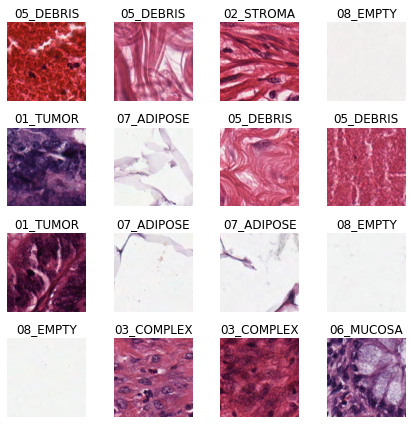

In [0]:
from fastai.vision import *
data = ImageDataBunch.from_folder('/content/drive/My Drive/Colab Notebooks/Kather_texture_2016_image_tiles_5000.zip (Unzipped Files)/Kather_texture_2016_image_tiles_5000', valid_pct=0.2, seed=123)
data.show_batch(rows=4, figsize=(6,6))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-04
Min loss divided by 10: 7.59E-03


epoch,train_loss,valid_loss,accuracy,time
0,0.735039,0.344467,0.884000,00:57
1,0.411801,0.275996,0.899000,00:53
2,0.279223,0.246492,0.909000,00:53


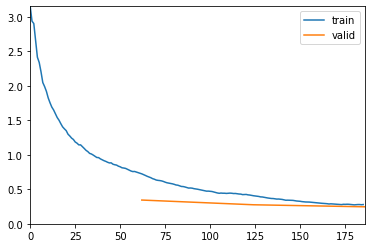

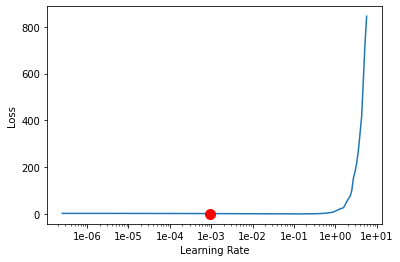

In [0]:
#optimal learning rate is found through lr_find and used as min_grad_lr
#maximium number of epochs without overfitting was found experimentally
learn = cnn_learner(data, models.vgg19_bn, metrics=accuracy, callback_fns=ShowGraph)
learn.lr_find(stop_div=False, num_it=200)
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit(3, min_grad_lr)


In [0]:
#this cell reads in the level 1 WSI for the first test image
working_dir = '/content/drive/My Drive/Colab Notebooks'
wsi_path = f'{working_dir}/im1.svs'

# read the wsi using function OpenSlide
wsi_obj = ops.OpenSlide(wsi_path)

# set the desired level
desired_level = 1

# get the thumbnail at desired level
thumbnail = wsi_obj.get_thumbnail(wsi_obj.level_dimensions[desired_level])
picarr = np.asarray(thumbnail)

#f, ax = plt.subplots(1, 1, figsize = (15, 15))
#ax.imshow(thumbnail)

In [0]:
#this function is a copy of the one previously defined, simply fetching the features for a given small patch of the WSI being segmented
def getFeats(patch):
  angs = [0, np.pi/4, np.pi/2, 3*np.pi/4]
  filt = np.zeros((150,150))
  feature = []
  grayim = rgb2gray(patch)
  #print(grayim.shape)
  intgrayim = np.multiply(grayim,255).astype(np.uint8)
  hist = histogram(grayim)[0]
  #print(hist.shape)
  mean = np.mean(hist)
  #print(mean)
  var = np.var(hist)
  #print(var)
  momf = moment(hist, 5)
  #print(momf)
  kurt = kurtosis(hist)
  #print(kurt)
  sk = skew(hist)
  #print(sk)
  mn = min(hist)
  mx = max(hist)
  lbp = local_binary_pattern(grayim, P=8, R=1, method='ror', )
  lbphist = histogram(lbp)[0]
  lmean = np.mean(lbphist)
  lvar = np.var(lbphist)
  lmomf = moment(lbphist, 5)
  lkurt = kurtosis(lbphist)
  lsk = skew(lbphist)
  lmn = min(lbphist)
  lmx = max(lbphist)
  gcm = greycomatrix(intgrayim, distances=[1,2,3,4,5], angles=angs, symmetric=True, normed=True)
  gcp = greycoprops(gcm)
  for ang in angs:
    for pix in [2,4,6,8,10,12]:
      filt += gabor(grayim, frequency=pix, theta=ang)[0]
  filt = np.divide(filt,24)
  fmean = np.mean(filt)
  fvar = np.var(filt)

  feature = [mean,var,momf,kurt,sk,mn,mx,lmean,lvar,lmomf,lkurt,lsk,lmn,lmx]
  for a in range(gcp.shape[0]):
    for b in range(gcp.shape[1]):
      feature.append(gcp[a, b])
  feature.append(fmean)
  feature.append(fvar)
  return feature




In [0]:
#compute the features for the first WSI
from scipy.stats import kurtosis, moment, skew
svmpreds = []
latest = 0

features = []

for x in range(0, picarr.shape[0],150):
  for y in range(0, picarr.shape[1], 150):
    patch = picarr[x:x+150,y:y+150,:]
    if patch.shape != (150,150,3):
      features.append(feature)
      continue
    feature = getFeats(patch)
    features.append(feature)

#predict the classes of these features
sfeatures = scaler.fit_transform(features)
spreds = clf.predict(sfeatures)

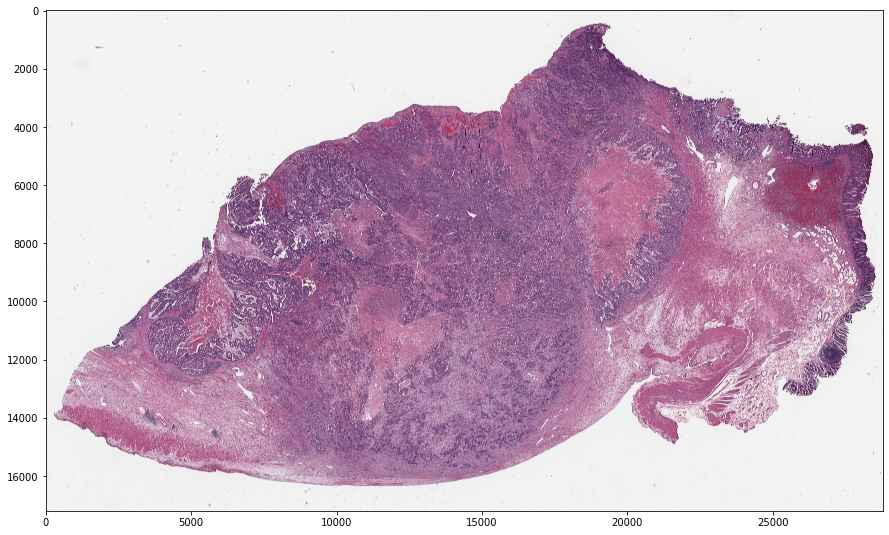

In [0]:
plt.figure(figsize=(15,15))
plt.imshow(picarr)
plt.show()

In [0]:
#maps predicted classes to colours in a copy of the WSI
#builds a simple mask which can be compared to the original WSI to view the segmentation easily
mapsvm = np.zeros((picarr.shape[0],picarr.shape[1]))
idx = 0
for x in range(0, picarr.shape[0],150):
  for y in range(0, picarr.shape[1], 150):
    mapsvm[x:x+150,y:y+150] = spreds[idx]
    idx+=1

plt.figure(figsize=(15,15))
plt.imshow(mapsvm, cmap="Set1")
plt.show()

In [0]:
#this cell reads in the level 1 WSI for the second test image
working_dir = '/content/drive/My Drive/Colab Notebooks'
wsi_path = f'{working_dir}/im2.svs'

# read the wsi using function OpenSlide
wsi_obj = ops.OpenSlide(wsi_path)

# set the desired level
desired_level = 1

# get the thumbnail at desired level
thumbnail = wsi_obj.get_thumbnail(wsi_obj.level_dimensions[desired_level])
picarr2 = np.asarray(thumbnail)

#f, ax = plt.subplots(1, 1, figsize = (15, 15))
#ax.imshow(thumbnail)

In [0]:
#compute the features for the first WSI
from scipy.stats import kurtosis, moment, skew
svmpreds = []
latest = 0
features = []

for x in range(0, picarr2.shape[0],150):
  for y in range(0, picarr2.shape[1], 150):
    patch = picarr2[x:x+150,y:y+150,:]
    if patch.shape != (150,150,3):
      features.append(feature)
      continue
    feature = getFeats(patch)
    features.append(feature)

#predict the classes of these features
sfeatures = scaler.transform(features)
s2preds = clf.predict(sfeatures)

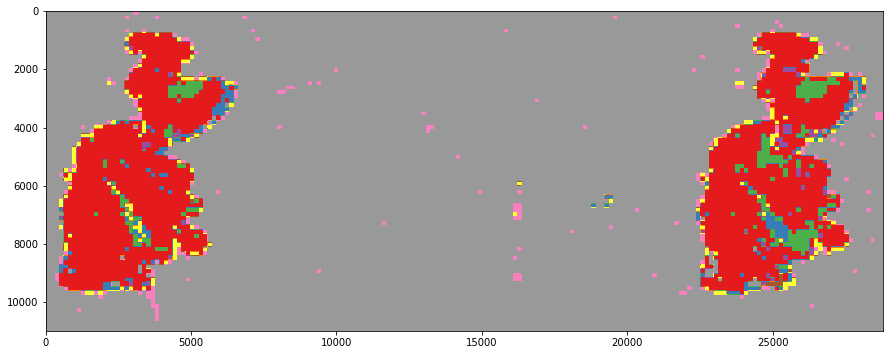

In [0]:
#maps predicted classes to colours in a copy of the WSI
#builds a simple mask which can be compared to the original WSI to view the segmentation easily
map2svm = np.zeros((picarr2.shape[0],picarr2.shape[1]))
idx = 0
for x in range(0, picarr2.shape[0],150):
  for y in range(0, picarr2.shape[1], 150):
    map2svm[x:x+150,y:y+150] = s2preds[idx]
    idx+=1

plt.figure(figsize=(15,15))
plt.imshow(map2svm, cmap="Set1")
plt.show()

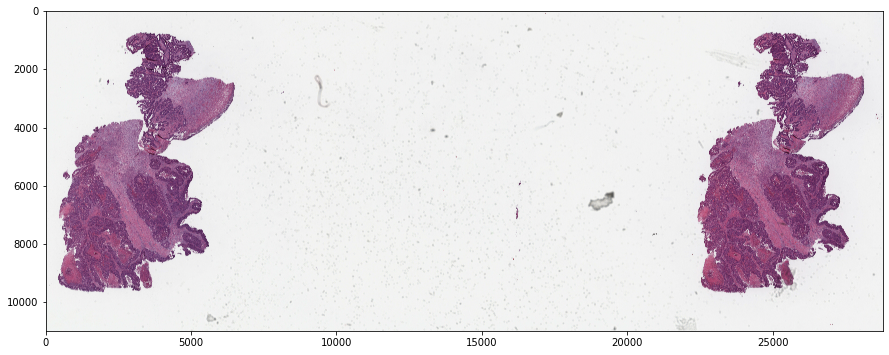

In [0]:
plt.figure(figsize=(15,15))
plt.imshow(picarr2)
plt.show()

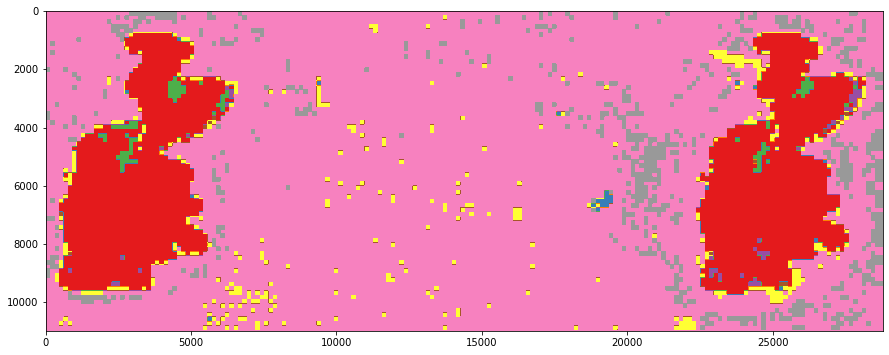

In [0]:
plt.figure(figsize=(15,15))
plt.imshow(map2svm, cmap="Set1")
plt.show()

The final few cells simply repeat the process just described in detail, step-by-step above. For brevity, further explanation/comment will not be included.

In [0]:
#numpy image arrays need to be converted to image tensor format for use with fastai
from fastai.vision import *
ipatches = []
for x in range(0, picarr.shape[0],150):
  for y in range(0, picarr.shape[1], 150):
    patch = picarr[x:x+150,y:y+150,:]
    if patch.shape != (150,150,3):
      #print("break")
      ipatches.append(prevpatch)
      continue
    #print(patch.shape)
    img_fastai = Image(pil2tensor(patch, dtype=np.float32).div_(255))
    #print(type(img_fastai))
    prevpatch = img_fastai
    ipatches.append(img_fastai)

In [0]:
#patches are classified
classifs = []
for p in ipatches:
  classifs.append(learn.predict(p)[0])
print(classifs)

[Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08

In [0]:
#classifications converted to integers
classvals = []
for c in classifs:
  res = str(c)
  if res=="08_EMPTY":
    classvals.append(7)
  elif res=="07_ADIPOSE":
    classvals.append(6)
  elif res=="06_MUCOSA":
    classvals.append(5)
  elif res=="05_DEBRIS":
    classvals.append(4)
  elif res=="04_LYMPHO":
    classvals.append(3)
  elif res=="03_COMPLEX":
    classvals.append(2)
  elif res=="02_STROMA":
    classvals.append(1)
  elif res=="01_TUMOR":
    classvals.append(0)

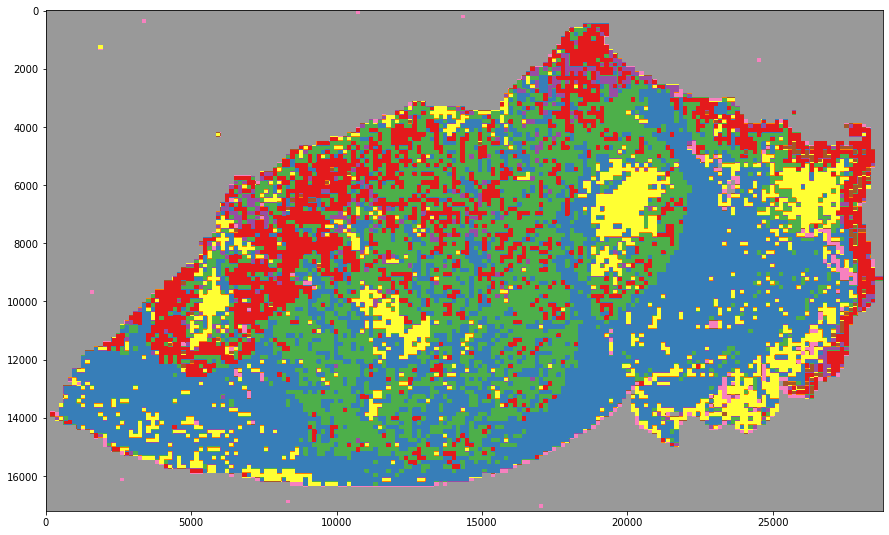

In [0]:
#integers mapped to colours to be shown as image mask
mapcnn = np.zeros((picarr.shape[0],picarr.shape[1]))
idx = 0
for x in range(0, picarr.shape[0],150):
  for y in range(0, picarr.shape[1], 150):
    mapcnn[x:x+150,y:y+150] = classvals[idx]
    idx+=1


plt.figure(figsize=(15,15))
plt.imshow(mapcnn, cmap="Set1")
plt.show()

In [0]:
#numpy image arrays need to be converted to image tensor format for use with fastai
i2patches = []
for x in range(0, picarr2.shape[0],150):
  for y in range(0, picarr2.shape[1], 150):
    patch = picarr2[x:x+150,y:y+150,:]
    if patch.shape != (150,150,3):
      #print("break")
      i2patches.append(prevpatch)
      continue
    #print(patch.shape)
    img_fastai = Image(pil2tensor(patch, dtype=np.float32).div_(255))
    #print(type(img_fastai))
    prevpatch = img_fastai
    i2patches.append(img_fastai)

In [0]:
#patches are classified using CNN
classifs2 = []
for p in i2patches:
  classifs2.append(learn.predict(p)[0])
print(classifs2)

[Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08_EMPTY, Category 08

In [0]:
#classifications are converted to integers
classvals2 = []
for c in classifs2:
  res = str(c)
  if res=="08_EMPTY":
    classvals2.append(7)
  elif res=="07_ADIPOSE":
    classvals2.append(6)
  elif res=="06_MUCOSA":
    classvals2.append(5)
  elif res=="05_DEBRIS":
    classvals2.append(4)
  elif res=="04_LYMPHO":
    classvals2.append(3)
  elif res=="03_COMPLEX":
    classvals2.append(2)
  elif res=="02_STROMA":
    classvals2.append(1)
  elif res=="01_TUMOR":
    classvals2.append(0)

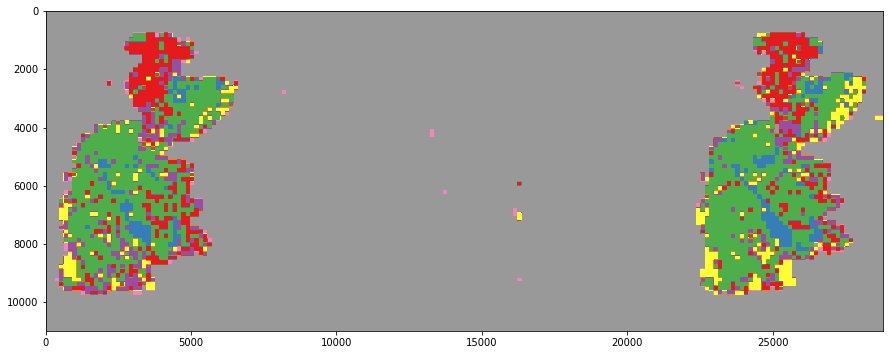

In [0]:
#integers mapped to colours to be shown as image mask
map2cnn = np.zeros((picarr2.shape[0],picarr2.shape[1]))
idx = 0
for x in range(0, picarr2.shape[0],150):
  for y in range(0, picarr2.shape[1], 150):
    map2cnn[x:x+150,y:y+150] = classvals2[idx]
    idx+=1


plt.figure(figsize=(15,15))
plt.imshow(map2cnn, cmap="Set1")
plt.show()